### 1. Start the environment


In [1]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 81kB 5.9MB/s ta 0:00:011
    100% |████████████████████████████████| 60.7MB 781kB/s eta 0:00:01    17% |█████▋                          | 10.6MB 46.8MB/s eta 0:00:02
    100% |████████████████████████████████| 6.4MB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 8.8MB 5.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 18.7MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 29.7MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 25.2MB/s ta 0:00:01
    100% |████████████████████████████████| 378kB 26.6MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 18.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.26 which is incompatib

In [2]:
import time
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from agent import Agent
%matplotlib inline

plt.style.use('ggplot')

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examining the State and Spaces of Action

In [5]:
# reset environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of Actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Start training

In [6]:
def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    parameters
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): epsilon start value, for epsilon-greedy action selection
        eps_end (float): minimum epsilon value
        eps_decay (float): multiplicative factor (per episode) to decrease epsilon
    """
    scores = []                        # list containing scores for each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save the most recent score
        scores.append(score)              # save the most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores 

agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn(env, agent)

Episode 100	Average Score: 1.28
Episode 200	Average Score: 4.81
Episode 300	Average Score: 8.48
Episode 400	Average Score: 10.64
Episode 467	Average Score: 13.01
Environment solved in 367 episodes!	Average Score: 13.01


### 4. Plot the scores

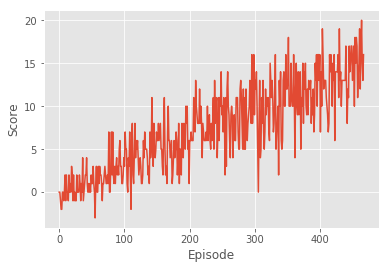

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### 5. Test the agent

In [8]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))


env_info = env.reset(train_mode=False)[brain_name]  # reset environment
state = env_info.vector_observations[0]             # get the current state
score = 0                                           # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    reward, next_state, done = env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
    
    score += reward                                # update score
    state = next_state                             # scroll state to next time step
    if done:                                       # exit loop if episode ended
        break
    
print("Score: {}".format(score))

Score: 10.0


In [9]:
env.close()